#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from sklearn.inspection import permutation_importance
import category_encoders as ce
from catboost import CatBoostRegressor, Pool
import arviz as az
import pymc3 as pm
import theano as tt
from theano import shared
from sklearn import preprocessing
import shap
import bambi as bmb
import formulae
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions

In [51]:
df = pd.read_csv('/home/matt/Documents/cortex_Push.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientId                                      54039 non-null  int64  
 1   Program Id                                    54039 non-null  int64  
 2   Program Name                                  54039 non-null  object 
 3   Retailers                                     54039 non-null  object 
 4   TacticId                                      54039 non-null  int64  
 5   Tactic                                        54039 non-null  object 
 6   CategoryId                                    54039 non-null  int64  
 7   Tactic Category                               54039 non-null  object 
 8   VendorId                                      53135 non-null  float64
 9   Vendor                                        54039 non-null 

Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or ped altogether

##### The following few sections analyze categorical, float, and int variables
##### so the dataset can be cleaned

In [3]:
# these drop column snippets are not used often here,
# but have been useful, especially with large datasets

df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date', 'Tactic End Date', 'Brand'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 2 categorical variables

The categorical variables are :

 ['Tactic Category', 'RMN']
Tactic Category    0.0
RMN                0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tactic Category  54039 non-null  object
 1   RMN              54039 non-null  object
dtypes: object(2)
memory usage: 844.5+ KB
Tactic Category    20
RMN                 2
dtype: int64


In [4]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

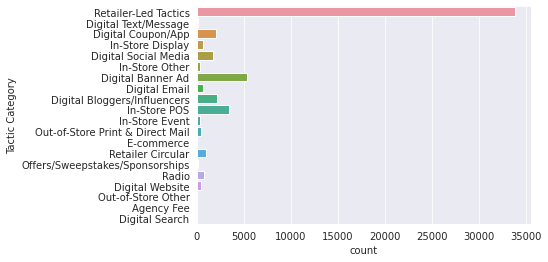

In [5]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [6]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 9 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'RMN', 'Weeks']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
RMN                             0
Weeks                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      54039 non-null  int64
 1   Program Id                    54039 non-null  int64
 2   TacticId                      54039 non-null  int64
 3   CategoryId                    54039 non-null  int64
 4   Total Impressions for Tactic  54

##### In the below section we address the large number of missing s and also
##### the columns consisting entirely of zeroes, and drop them accordingly

In [7]:
df = df.drop(
        ['Base $', 'Incr $', 'Base Units', 'Incr Units',
         '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
         'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 24 float variables

The float variables are :

 ['VendorId', 'Total Tactic Spend', 'Total Tactic Insertion Cost', 'Total Tactic Redemption Cost', 'StoreCount', 'Impressions per Week', 'Brand Share of Program Budget', 'Brand Share of Total Tactic Spend', 'Brand Share of Tactic Insertion Cost', 'Brand Share of Tactic Redemption Cost', 'Weekly Brand Share of Total Tactic Spend', 'Weekly Brand Share of Tactic Insertion Cost', 'Weekly Brand Share of Tactic Redemption Cost', 'Total Sales', 'Units', 'Avg Unit Price', 'Any Promo Units', '%ACV Distribution', 'Any Promo %ACV', 'Disp w/o Feat %ACV', 'Feat & Disp %ACV', 'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Number of UPCs Selling']
Total Sales               62.036677
Units                     62.036677
Avg Unit Price            62.021873
Any Promo Units           62.021873
%ACV Distribution         62.099595
Any Promo %ACV            62.099595
Disp w/o Feat %ACV        62.099595
Feat & Disp %ACV          62.099595
Feat w/o Disp 

In [8]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,5.403900e+04,54039.000000,54039.000000,54039.000000,54031.000000,54039.000000,54039.000000,5.403900e+04,54039.000000,54039.000000,...,2.051500e+04,20523.000000,2.052300e+04,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20523.000000
mean,3.408857e+07,33927.000842,27540.179030,6386.821813,1033.474764,0.212513,8.902885,3.044121e+06,0.239102,7075.707566,...,1.984949e+05,5.651272,6.032207e+04,86.373085,45.409581,2.082658,0.820302,17.774523,36.872715,16.736686
std,3.680617e+08,61813.987485,61974.946222,12328.696054,1304.144639,0.409090,5.067866,3.048686e+07,0.291679,14125.204066,...,4.354113e+05,2.231451,1.662932e+05,25.044837,33.745145,5.432150,3.497597,27.201852,31.021937,16.984060
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.331000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.269400e+04,8714.000000,4494.000000,0.000000,0.000000,0.000000,6.000000,7.064667e+03,0.056904,635.431163,...,2.088150e+04,4.000000,2.202813e+03,91.901000,12.753000,0.000000,0.000000,0.000000,7.571000,6.000000
50%,3.000000e+05,20000.000000,10480.890000,0.000000,0.000000,0.000000,8.000000,3.739900e+04,0.123091,2291.429059,...,7.331000e+04,5.149000,1.539920e+04,98.872000,43.668000,0.000000,0.000000,0.900000,30.984000,11.000000
75%,3.800838e+06,40000.000000,29994.800000,9750.000000,2277.000000,0.000000,12.000000,5.371706e+05,0.271429,6725.352668,...,1.814967e+05,7.119000,5.465139e+04,99.761000,74.771000,1.900000,0.000000,26.047000,61.200000,20.000000
max,4.750000e+09,690000.000000,690000.000000,151705.000000,15000.000000,1.000000,61.000000,4.500000e+08,1.000000,187676.881500,...,3.600584e+06,14.957000,2.074647e+06,100.000000,100.000000,66.782000,58.213000,100.000000,100.000000,83.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.080769,0.144231,0.129615,0.019231,0.096538,0.030385,0.029615,0.073462,0.061923,0.158846,...,0.188462,0.001154,0.191923,0.162308,0.180769,0.117692,0.118846,0.121923,0.158077,0.160000
std,0.350724,0.372539,0.414299,0.388092,0.218430,0.263173,0.294435,0.354851,0.348861,0.446975,...,0.352156,0.222231,0.404693,0.302302,0.365906,0.266268,0.309649,0.361420,0.364077,0.387866
min,-0.530000,-0.290000,-0.290000,-0.520000,-0.170000,-0.350000,-0.460000,-0.520000,-0.350000,-0.310000,...,-0.220000,-0.290000,-0.290000,-0.140000,-0.200000,-0.170000,-0.240000,-0.320000,-0.240000,-0.350000
25%,-0.010000,-0.162500,-0.187500,-0.140000,-0.007500,-0.110000,-0.165000,-0.047500,-0.157500,-0.180000,...,-0.080000,-0.070000,-0.130000,-0.087500,-0.155000,-0.097500,-0.105000,-0.162500,-0.167500,-0.120000
50%,0.025000,0.065000,-0.085000,-0.060000,0.070000,0.035000,0.015000,0.020000,-0.045000,-0.005000,...,0.095000,-0.010000,0.055000,0.020000,0.045000,0.115000,0.090000,0.045000,0.050000,0.080000
75%,0.185000,0.237500,0.397500,0.020000,0.170000,0.157500,0.177500,0.200000,0.067500,0.545000,...,0.362500,0.022500,0.590000,0.450000,0.397500,0.240000,0.282500,0.367500,0.400000,0.505000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


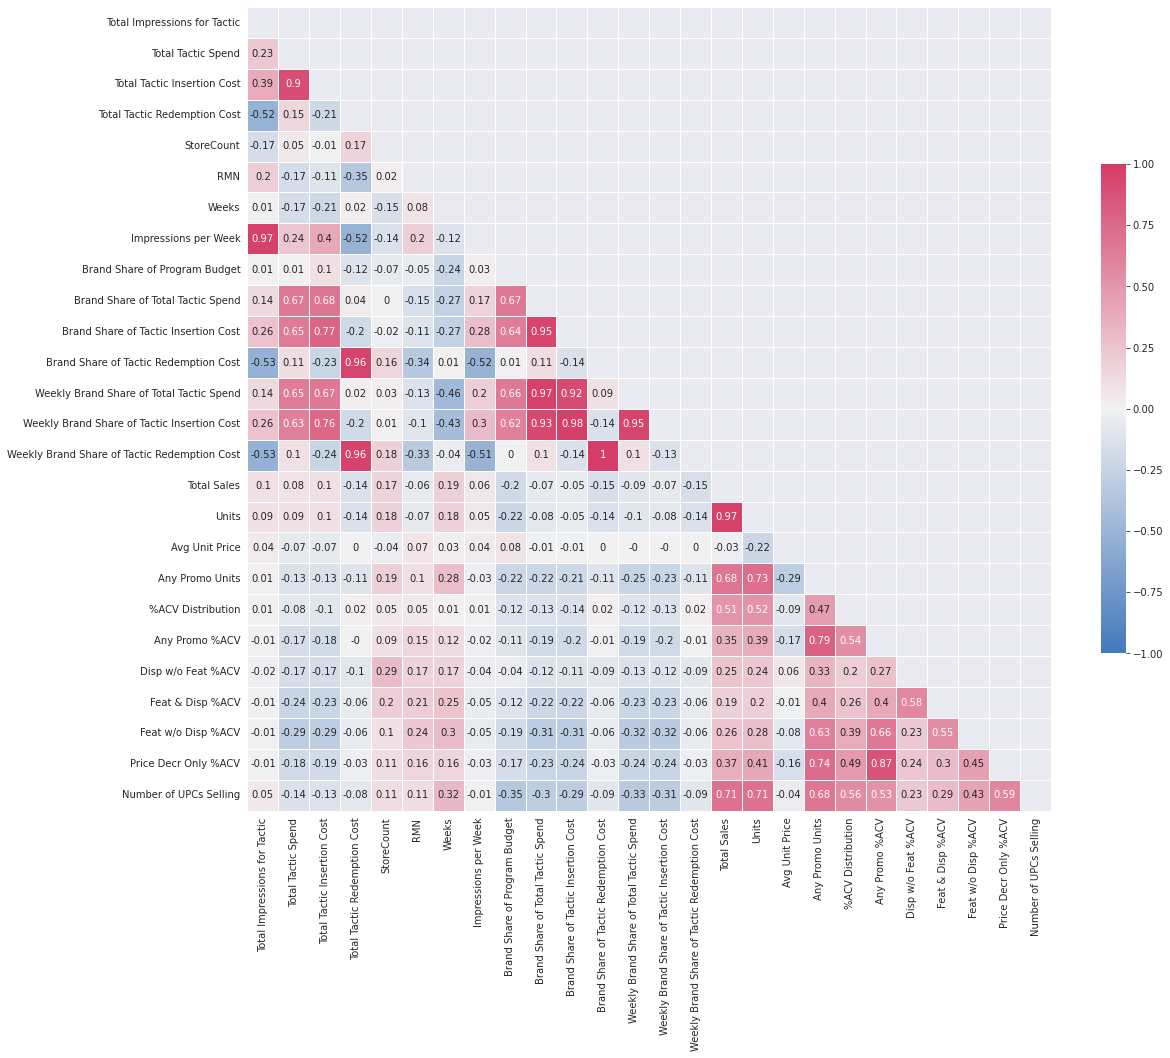

In [9]:
# This first heat map may become more important when categorical variables
# are included in the model

corr = df_num.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

                                         feature       VIF
0                   Total Impressions for Tactic  1.189348
1                             Total Tactic Spend       inf
2                    Total Tactic Insertion Cost       inf
3                   Total Tactic Redemption Cost       inf
4                                     StoreCount  1.416414
5                                            RMN  1.752035
6                                          Weeks  4.361506
7                  Brand Share of Program Budget  2.814842
8              Brand Share of Total Tactic Spend       inf
9           Brand Share of Tactic Insertion Cost       inf
10         Brand Share of Tactic Redemption Cost       inf
11      Weekly Brand Share of Total Tactic Spend       inf
12   Weekly Brand Share of Tactic Insertion Cost       inf
13  Weekly Brand Share of Tactic Redemption Cost       inf
14                                   Total Sales  2.680153
15                                Avg Unit Price  4.7219

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Brand Share of Program Budget,Brand Share of Total Tactic Spend,Brand Share of Tactic Insertion Cost,...,Weekly Brand Share of Tactic Insertion Cost,Weekly Brand Share of Tactic Redemption Cost,Total Sales,Avg Unit Price,Any Promo Units,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.00000,22.000000,22.000000,22.000000,...,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.068182,0.167273,0.150455,0.101818,0.072273,-0.047727,-0.01500,0.108182,0.194091,0.178182,...,0.169545,0.105455,0.140909,0.022273,0.137727,0.108636,0.103636,0.085909,0.107727,0.108182
std,0.263992,0.461995,0.469980,0.371517,0.238086,0.358687,0.37575,0.381484,0.514510,0.517178,...,0.526828,0.373551,0.312652,0.233359,0.392852,0.284593,0.327902,0.366524,0.347932,0.380859
min,-0.250000,-0.460000,-0.490000,-0.250000,-0.220000,-0.500000,-0.56000,-0.370000,-0.470000,-0.500000,...,-0.540000,-0.240000,-0.200000,-0.300000,-0.300000,-0.170000,-0.240000,-0.320000,-0.240000,-0.350000
25%,-0.017500,-0.160000,-0.157500,-0.095000,-0.040000,-0.407500,-0.36250,-0.185000,-0.220000,-0.217500,...,-0.230000,-0.090000,-0.070000,-0.047500,-0.190000,-0.107500,-0.195000,-0.265000,-0.177500,-0.127500
50%,0.020000,0.050000,-0.080000,-0.025000,-0.010000,-0.060000,0.02500,0.020000,0.060000,-0.015000,...,-0.005000,-0.020000,0.090000,0.000000,-0.050000,0.020000,-0.010000,-0.035000,-0.020000,0.000000
75%,0.167500,0.652500,0.642500,0.102500,0.110000,0.147500,0.23500,0.160000,0.742500,0.742500,...,0.737500,0.110000,0.235000,0.022500,0.382500,0.237500,0.280000,0.290000,0.285000,0.312500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


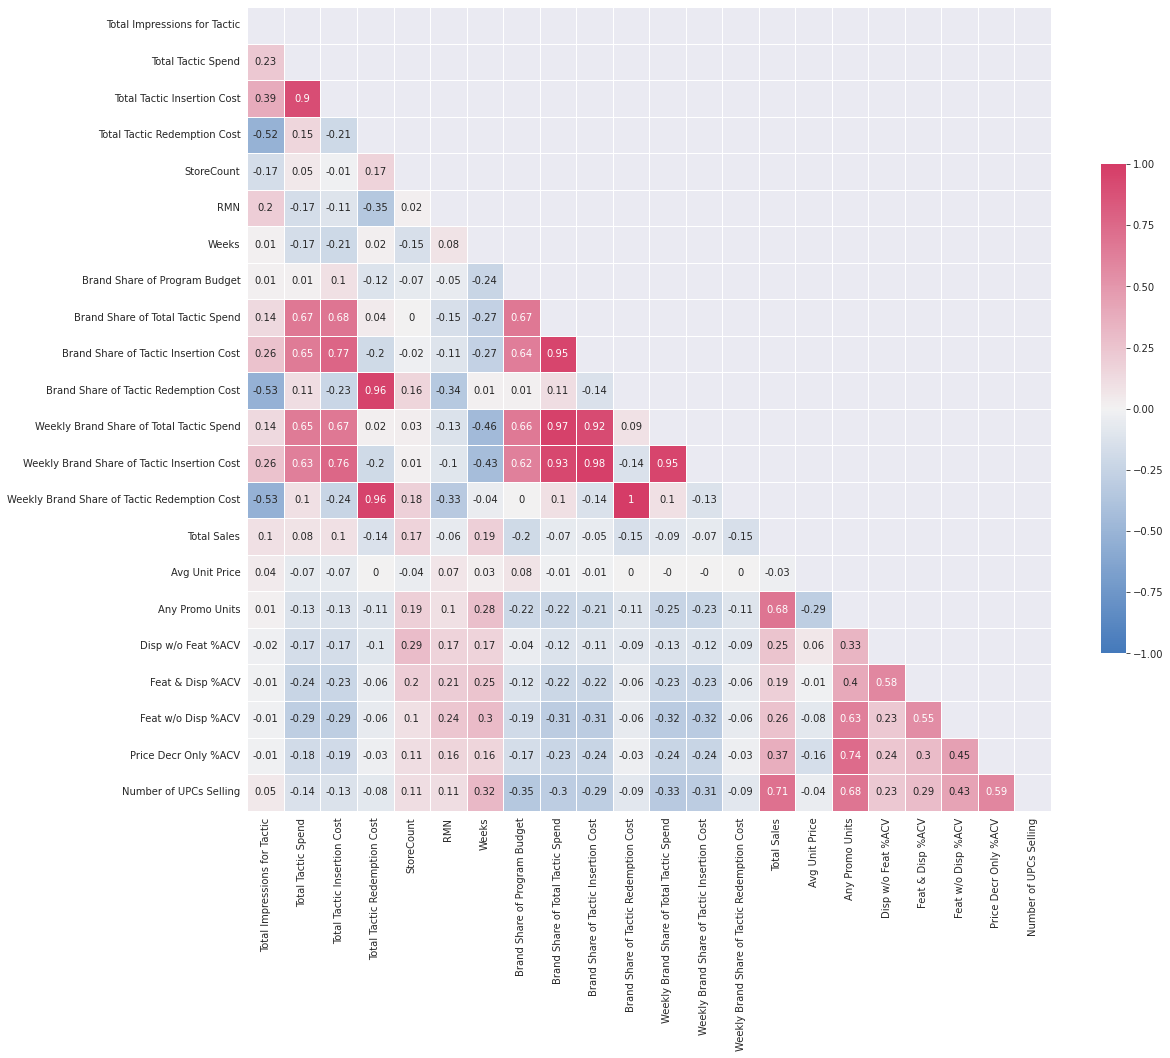

In [147]:
# check for new dataframes

vif_df = df_num[~df_num.isin([np.nan, np.inf, -np.inf]).any(1)]

X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_vif.describe()

In [12]:
# keep Total Sales from the VIF calculation, Units due to its relationship to Total Sales
# drop either Total Impressions or Impressions per Week
# drop Any Promo % ACV because of its relationship to all other promos
# corr = corr.drop(['Units', 'Impressions per Week',
#                   'Any Promo %ACV', '%ACV Distribution'], axis=1)

df_num = df_num.drop(['Units', 'Impressions per Week',
                      'Any Promo %ACV', '%ACV Distribution'], axis=1)
corr = df_num.corr(method="spearman").round(2)

In [13]:
def imp_plots(target, features):
    """Form three importance plots

    :param target:'dependent' component
    :param features:'predictive' component
    """
    target = target
    df_all = df_num.dropna().astype(dtype='int32')
    df_all = df_all[features + [target]]
    df_train, df_test = train_test_split(df_all, test_size=0.15)
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                max_features=1.0,
                                min_samples_leaf=10, oob_score=True)
    rf.fit(X_train, y_train)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                           oob_score=True, random_state=None, verbose=0, warm_start=False)
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    imp1 = importances(rf, X_test, y_test)
    plot_importances(imp1, width=16, vscale=4, ax=ax1)

    imp = pd.DataFrame()
    imp['Feature'] = X_train.columns
    imp['Importance'] = rf.feature_importances_
    imp = imp.sort_values('Importance', ascending=False)
    imp2 = imp.set_index('Feature')
    plot_importances(imp2, width=16, vscale=4, ax=ax2)

    perm_importance = permutation_importance(rf, X_test, y_test)
    perm = pd.DataFrame()
    perm['Feature'] = X_test.columns
    perm['Importance'] = perm_importance.importances_mean
    perm = perm.sort_values('Importance', ascending=False)
    perm = perm.set_index('Feature')
    plot_importances(perm, width=16, vscale=4, ax=ax3)
    a = imp1.sort_values(by='Feature')
    b = imp2.sort_values(by='Feature')
    c = perm.sort_values(by='Feature')
    d = (np.abs(a) + np.abs(b) + np.abs(c)).sort_values('Importance', ascending=False).mean(axis=1)
    plt.show()
    return d

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

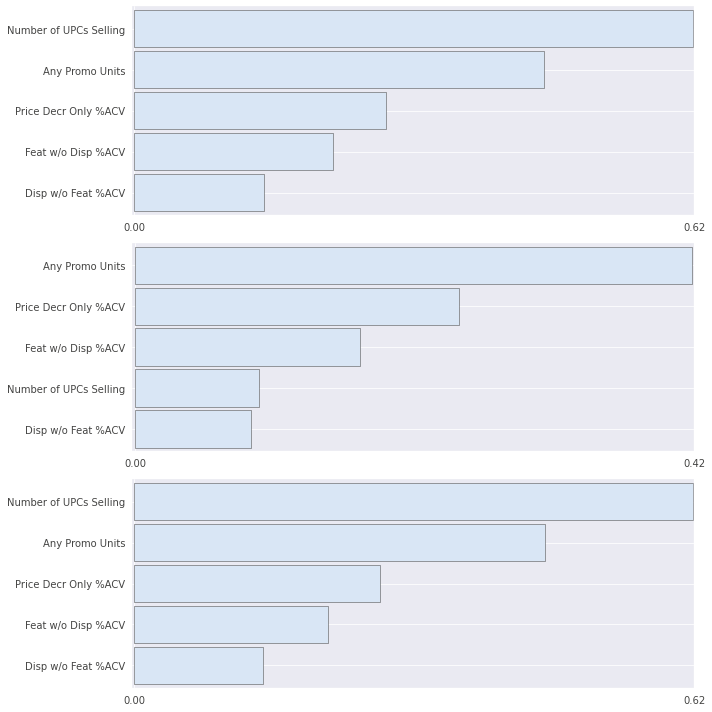

Feature
Number of UPCs Selling    1.329372
Any Promo Units           1.322336
Price Decr Only %ACV      0.792013
Feat w/o Disp %ACV        0.601260
Disp w/o Feat %ACV        0.372526
dtype: float64


In [14]:
corr_imp = corr[abs(corr['Total Sales'] > .20) & (corr['Total Sales'] < 1.0)]
corr_imp = corr_imp[['Total Sales']]
features = corr_imp.index.tolist()
imp_sales = imp_plots('Total Sales', features)
print(imp_sales)

Once the previous importance plots have given us insight into the most important
variables at that level of the hierarchy, we can continue by choosing the most important
for the next level of the hierarchy

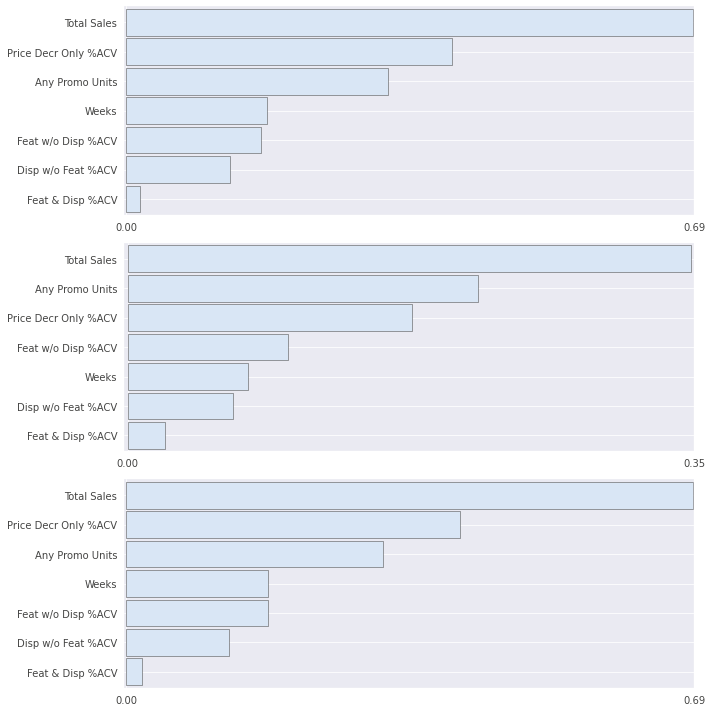

Feature
Total Sales             1.729644
Price Decr Only %ACV    0.980367
Any Promo Units         0.848133
Feat w/o Disp %ACV      0.435740
Weeks                   0.419377
Disp w/o Feat %ACV      0.317206
Feat & Disp %ACV        0.059445
dtype: float64


In [15]:
corr_imp = corr[
    abs(corr['Number of UPCs Selling'] > .20) & (corr['Number of UPCs Selling'] < 1.0)]
corr_imp = corr_imp[['Number of UPCs Selling']]
features = corr_imp.index.tolist()
imp_UPC = imp_plots('Number of UPCs Selling', features)
print(imp_UPC)

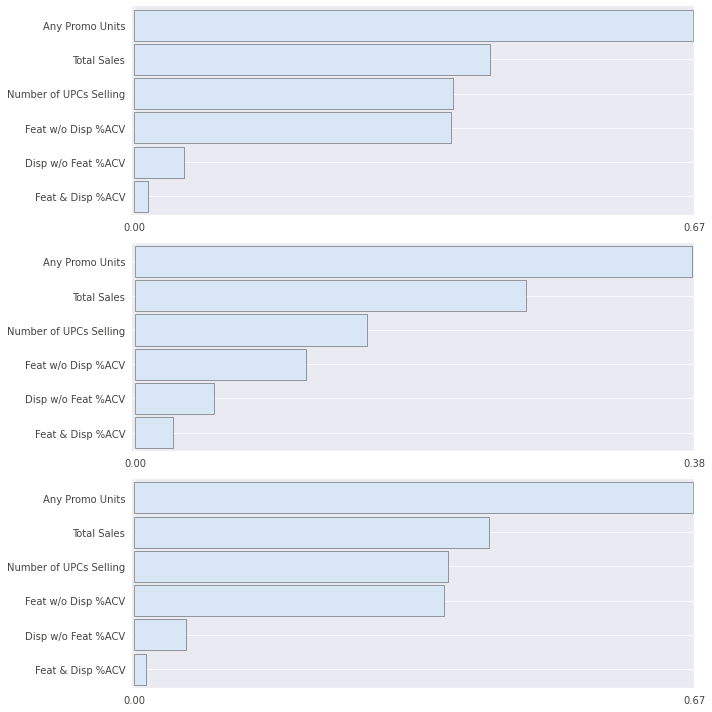

Feature
Any Promo Units           1.717526
Total Sales               1.117253
Number of UPCs Selling    0.915678
Feat w/o Disp %ACV        0.866824
Disp w/o Feat %ACV        0.176122
Feat & Disp %ACV          0.056776
dtype: float64


In [16]:
corr_imp = corr[abs(corr['Price Decr Only %ACV'] > .20) & (corr['Price Decr Only %ACV'] < 1.0)]
corr_imp = corr_imp[['Price Decr Only %ACV']]
features = corr_imp.index.tolist()
imp_price_decr = imp_plots('Price Decr Only %ACV', features)
print(imp_price_decr)

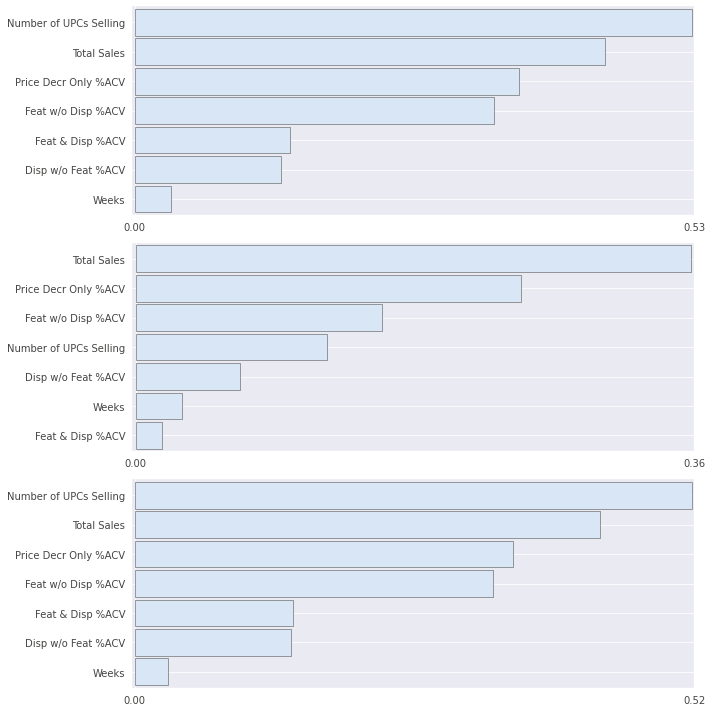

Feature
Total Sales               1.234514
Number of UPCs Selling    1.169308
Price Decr Only %ACV      0.962943
Feat w/o Disp %ACV        0.831321
Disp w/o Feat %ACV        0.350383
Feat & Disp %ACV          0.311017
Weeks                     0.095216
dtype: float64


In [17]:
corr_imp = corr[abs(corr['Any Promo Units'] > .20) & (corr['Any Promo Units'] < 1.0)]
corr_imp = corr_imp[['Any Promo Units']]
features = corr_imp.index.tolist()
imp_promo_unit = imp_plots('Any Promo Units', features)
print(imp_promo_unit)

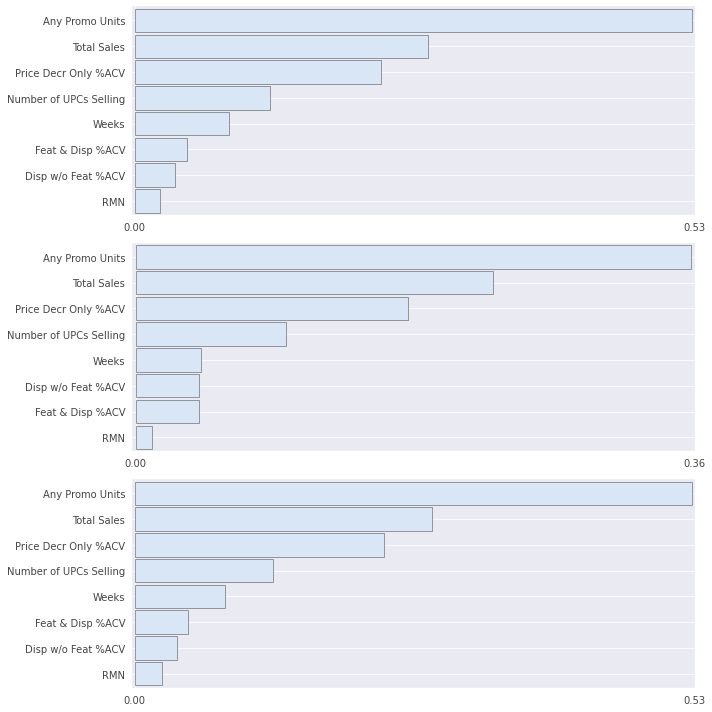

Feature
Any Promo Units           1.420959
Total Sales               0.794168
Price Decr Only %ACV      0.648071
Number of UPCs Selling    0.357954
Weeks                     0.218904
Feat & Disp %ACV          0.141388
Disp w/o Feat %ACV        0.119907
RMN                       0.061357
dtype: float64


In [18]:
corr_imp = corr[abs(corr['Feat w/o Disp %ACV'] > .20) & (corr['Feat w/o Disp %ACV'] < 1.0)]
corr_imp = corr_imp[['Feat w/o Disp %ACV']]
features = corr_imp.index.tolist()
imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

#### 2. This section continues on to modeling and exploration of modeling techniques

In [49]:
final_vars_cat = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'Weeks', 'RMN','Tactic Category',
                  'Brand']

final_vars = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [20]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Number of UPCs Selling
         sumsquare_error          aic            bic  kl_div
gamma           0.013375  1075.968649 -292293.237680     inf
expon           0.014814  1063.437196 -290205.813534     inf
cauchy          0.016145  1186.153183 -288439.471614     inf
norm            0.025284  1165.841763 -279234.115072     inf
uniform         0.035964   887.768122 -272003.307866     inf
{'gamma': {'a': 1.1546879907984438, 'loc': -0.0074750016901030895, 'scale': 14.500983104854907}}
Any Promo Units
         sumsquare_error           aic            bic  kl_div
cauchy      2.123850e-11  3.745221e+03 -708116.143728     inf
expon       1.891835e-10  5.644774e+03 -663234.352935     inf
norm        6.276788e-10  7.341008e+03 -638620.889651     inf
uniform     7.617030e-10  2.913060e+03 -634649.112487     inf
gamma       7.849363e-10  6.428922e+07 -634022.551167     NaN
{'cauchy': {'loc': 9127.707279836573, 'scale': 13423.69390246777}}
%ACV Distribution
         sumsquare_error          aic    

Here I test the Bambi package based on PyMC3 to establish a baseline for a
simpler model, though I use the same plots, more or less

In [21]:
df_final_nz = df_final[df_final['Total Sales'] > 0.0]

df_nostr = df_final_nz
df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')

df_nostr['TotalSales'] = np.log(df_nostr['TotalSales'])

The default value of regex will change from True to False in a future version.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
bmb_model = bmb.Model('TotalSales ~ NumberofUPCsSelling + '
                      ' FeatwoDispACV + PriceDecrOnlyACV + FeatDispACV'
                      '+ DispwoFeatACV', data=df_nostr, dropna=False)

bmb_fitted = bmb_model.fit(draws=4000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TotalSales_sigma, DispwoFeatACV, FeatDispACV, PriceDecrOnlyACV, FeatwoDispACV, NumberofUPCsSelling, Intercept]
INFO:pymc3:NUTS: [TotalSales_sigma, DispwoFeatACV, FeatDispACV, PriceDecrOnlyACV, FeatwoDispACV, NumberofUPCsSelling, Intercept]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 112 seconds.
INFO:pymc3:Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 112 seconds.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            11.522  0.016  11.493   11.552        0.0      0.0   
NumberofUPCsSelling   0.051  0.001   0.049    0.052        0.0      0.0   
FeatwoDispACV         0.004  0.000   0.003    0.005        0.0      0.0   
PriceDecrOnlyACV      0.003  0.000   0.002    0.003        0.0      0.0   
FeatDispACV          -0.052  0.003  -0.058   -0.046        0.0      0.0   
DispwoFeatACV         0.053  0.002   0.049    0.056        0.0      0.0   
TotalSales_sigma      1.375  0.007   1.362    1.388        0.0      0.0   

                     ess_bulk  ess_tail  r_hat  
Intercept             20935.0   14239.0    1.0  
NumberofUPCsSelling   14835.0   13538.0    1.0  
FeatwoDispACV         14677.0   12872.0    1.0  
PriceDecrOnlyACV      14873.0   13214.0    1.0  
FeatDispACV           14481.0   13245.0    1.0  
DispwoFeatACV         16331.0   12962.0    1.0  
TotalSales_sigma      20380.0   13105.0    1.0  
<xarray

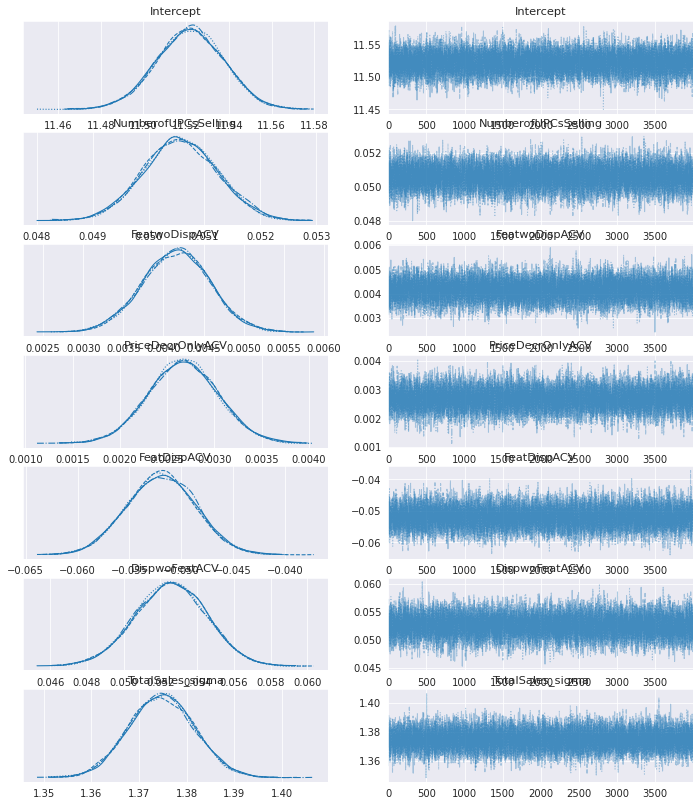

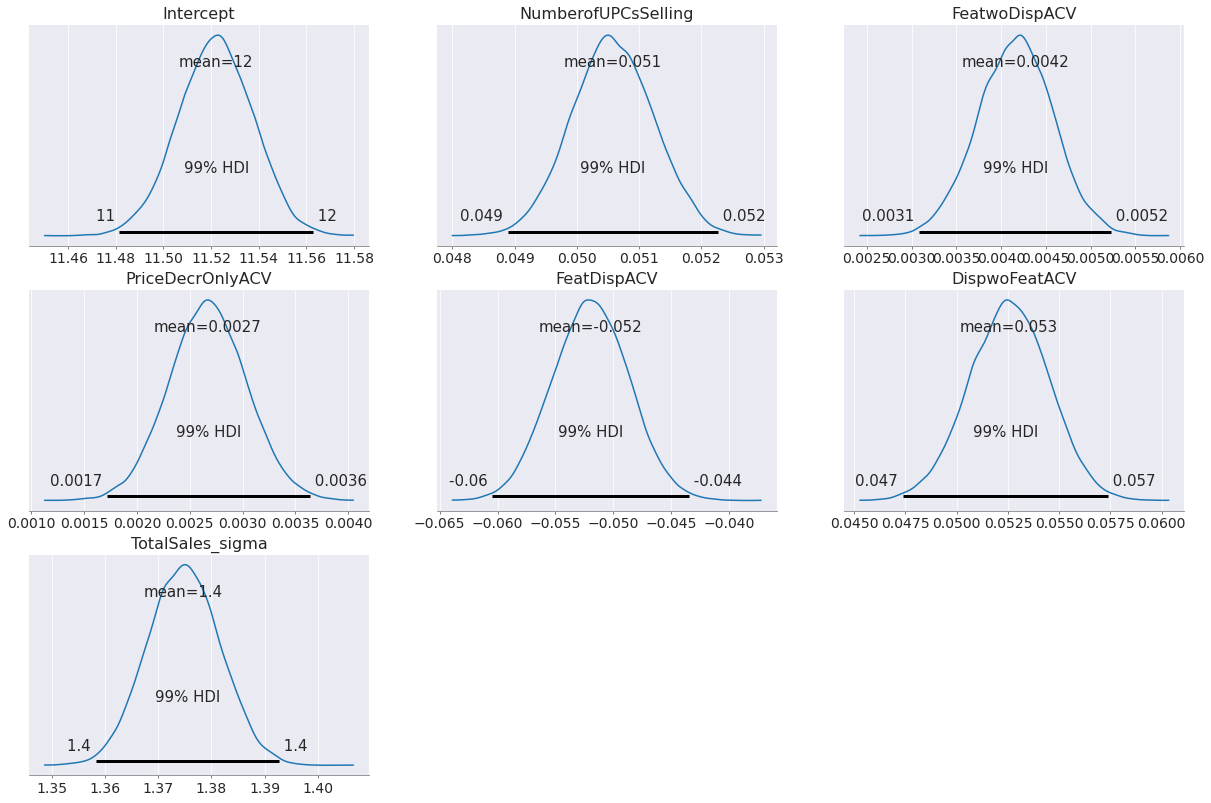

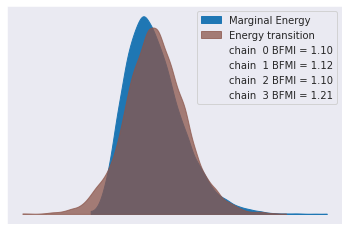

In [31]:
az.plot_trace(bmb_fitted)
print(az.summary(bmb_fitted))
az.mcse(bmb_fitted)
print(az.ess(bmb_fitted))
az.plot_posterior(bmb_fitted, hdi_prob=0.99);
az.plot_energy(bmb_fitted);

In [53]:
df_final_cat = df[final_vars_cat]

df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

The following two charts show that many Tactic Category observations have dropped and two categories have also dropped.

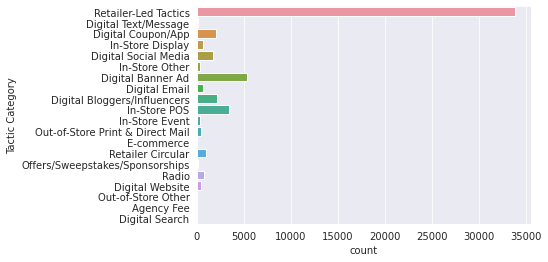

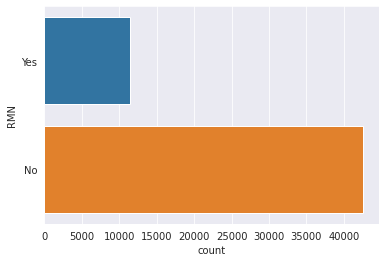

54039


In [54]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()
print(df['Tactic Category'].count())

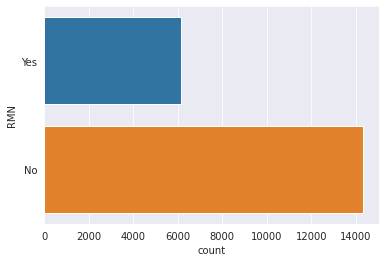

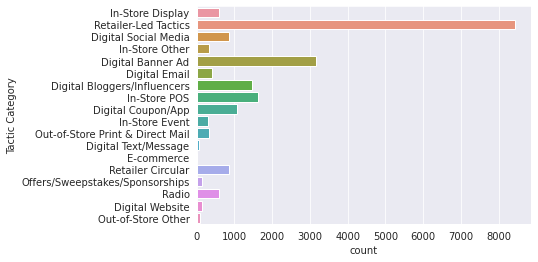

20481
18
46


In [57]:
for col in df_final_cat.select_dtypes(include='object'):
    if df_final_cat[col].nunique() <= 25:
        sns.countplot(y=col, data=df_final_cat)
        plt.show()
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

In [127]:
tt.config.floatX = 'float64'
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs))}

In [146]:
with pm.Model(coords=coords) as hierarchical_model:
    tactic_idx = pm.Data("tactic_idx", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("brand", brand_idxs, dims="obs_idx")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="tactics")
    # effect difference between basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="tactics")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[tactic_idx] + b[tactic_idx] * brand_idx

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=df_final_cat['Total Sales'], dims="obs_idx"
    )
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=2500, init='advi+adapt_diag', tune=2500, target_accept=0.99, return_inferencedata=True)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 42700
INFO:pymc3.variational.inference:Convergence achieved at 42700
Interrupted at 42,699 [21%]: Average Loss = 1.5326e+14
INFO:pymc3.variational.inference:Interrupted at 42,699 [21%]: Average Loss = 1.5326e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 2045 seconds.
INFO:pymc3:Sampling 4 chains for 2_500 tune and 2_500 draw iterations (10_000 + 10_000 draws total) took 2045 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9716844705435337, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Incre

                                            mean        sd       hdi_3%  \
mu_a                                      78.460    94.945     -106.455   
mu_b                                    1141.857    97.184      970.950   
a[Digital Banner Ad]                      78.383    95.151     -101.801   
a[Digital Bloggers/Influencers]           78.351    95.162     -106.295   
a[Digital Coupon/App]                     78.597    95.146     -105.779   
a[Digital Email]                          78.411    95.090     -103.333   
a[Digital Social Media]                   78.450    95.135     -103.857   
a[Digital Text/Message]                   78.439    95.129     -104.414   
a[Digital Website]                        78.404    95.022     -105.395   
a[E-commerce]                             78.516    95.211     -102.550   
a[In-Store Display]                       78.448    95.062     -101.335   
a[In-Store Event]                         78.529    95.063     -102.602   
a[In-Store Other]        

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (41) in plot_posterior, generating only 40 plots


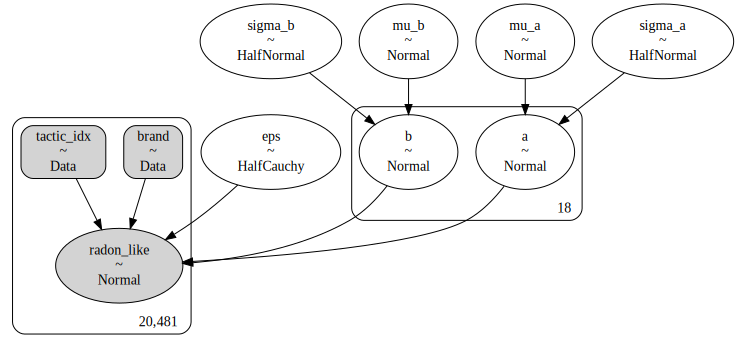

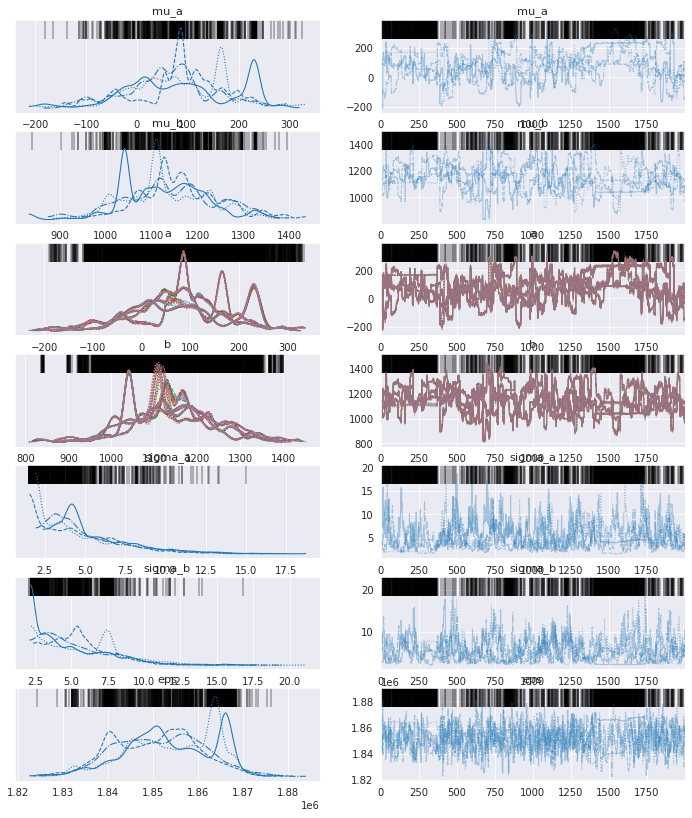

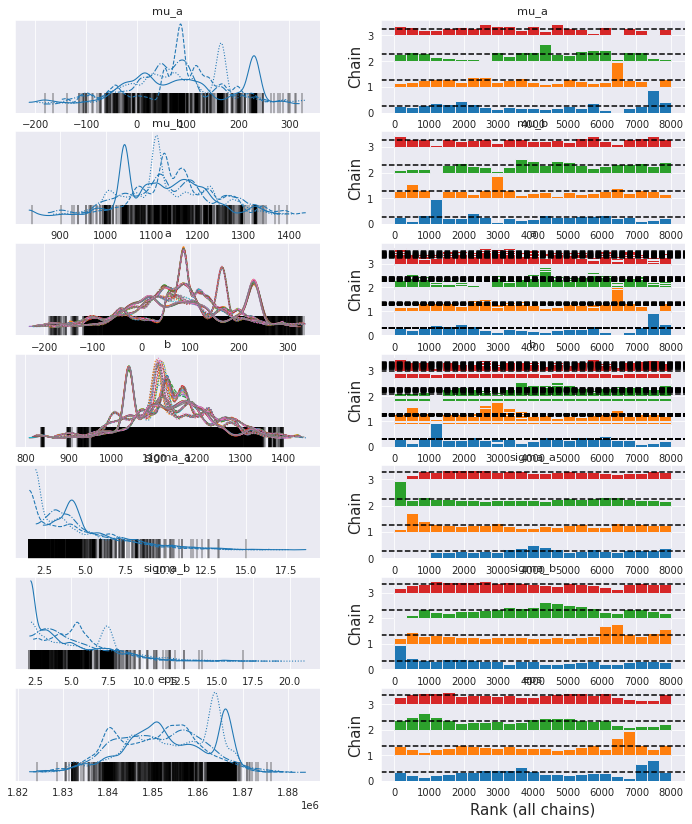

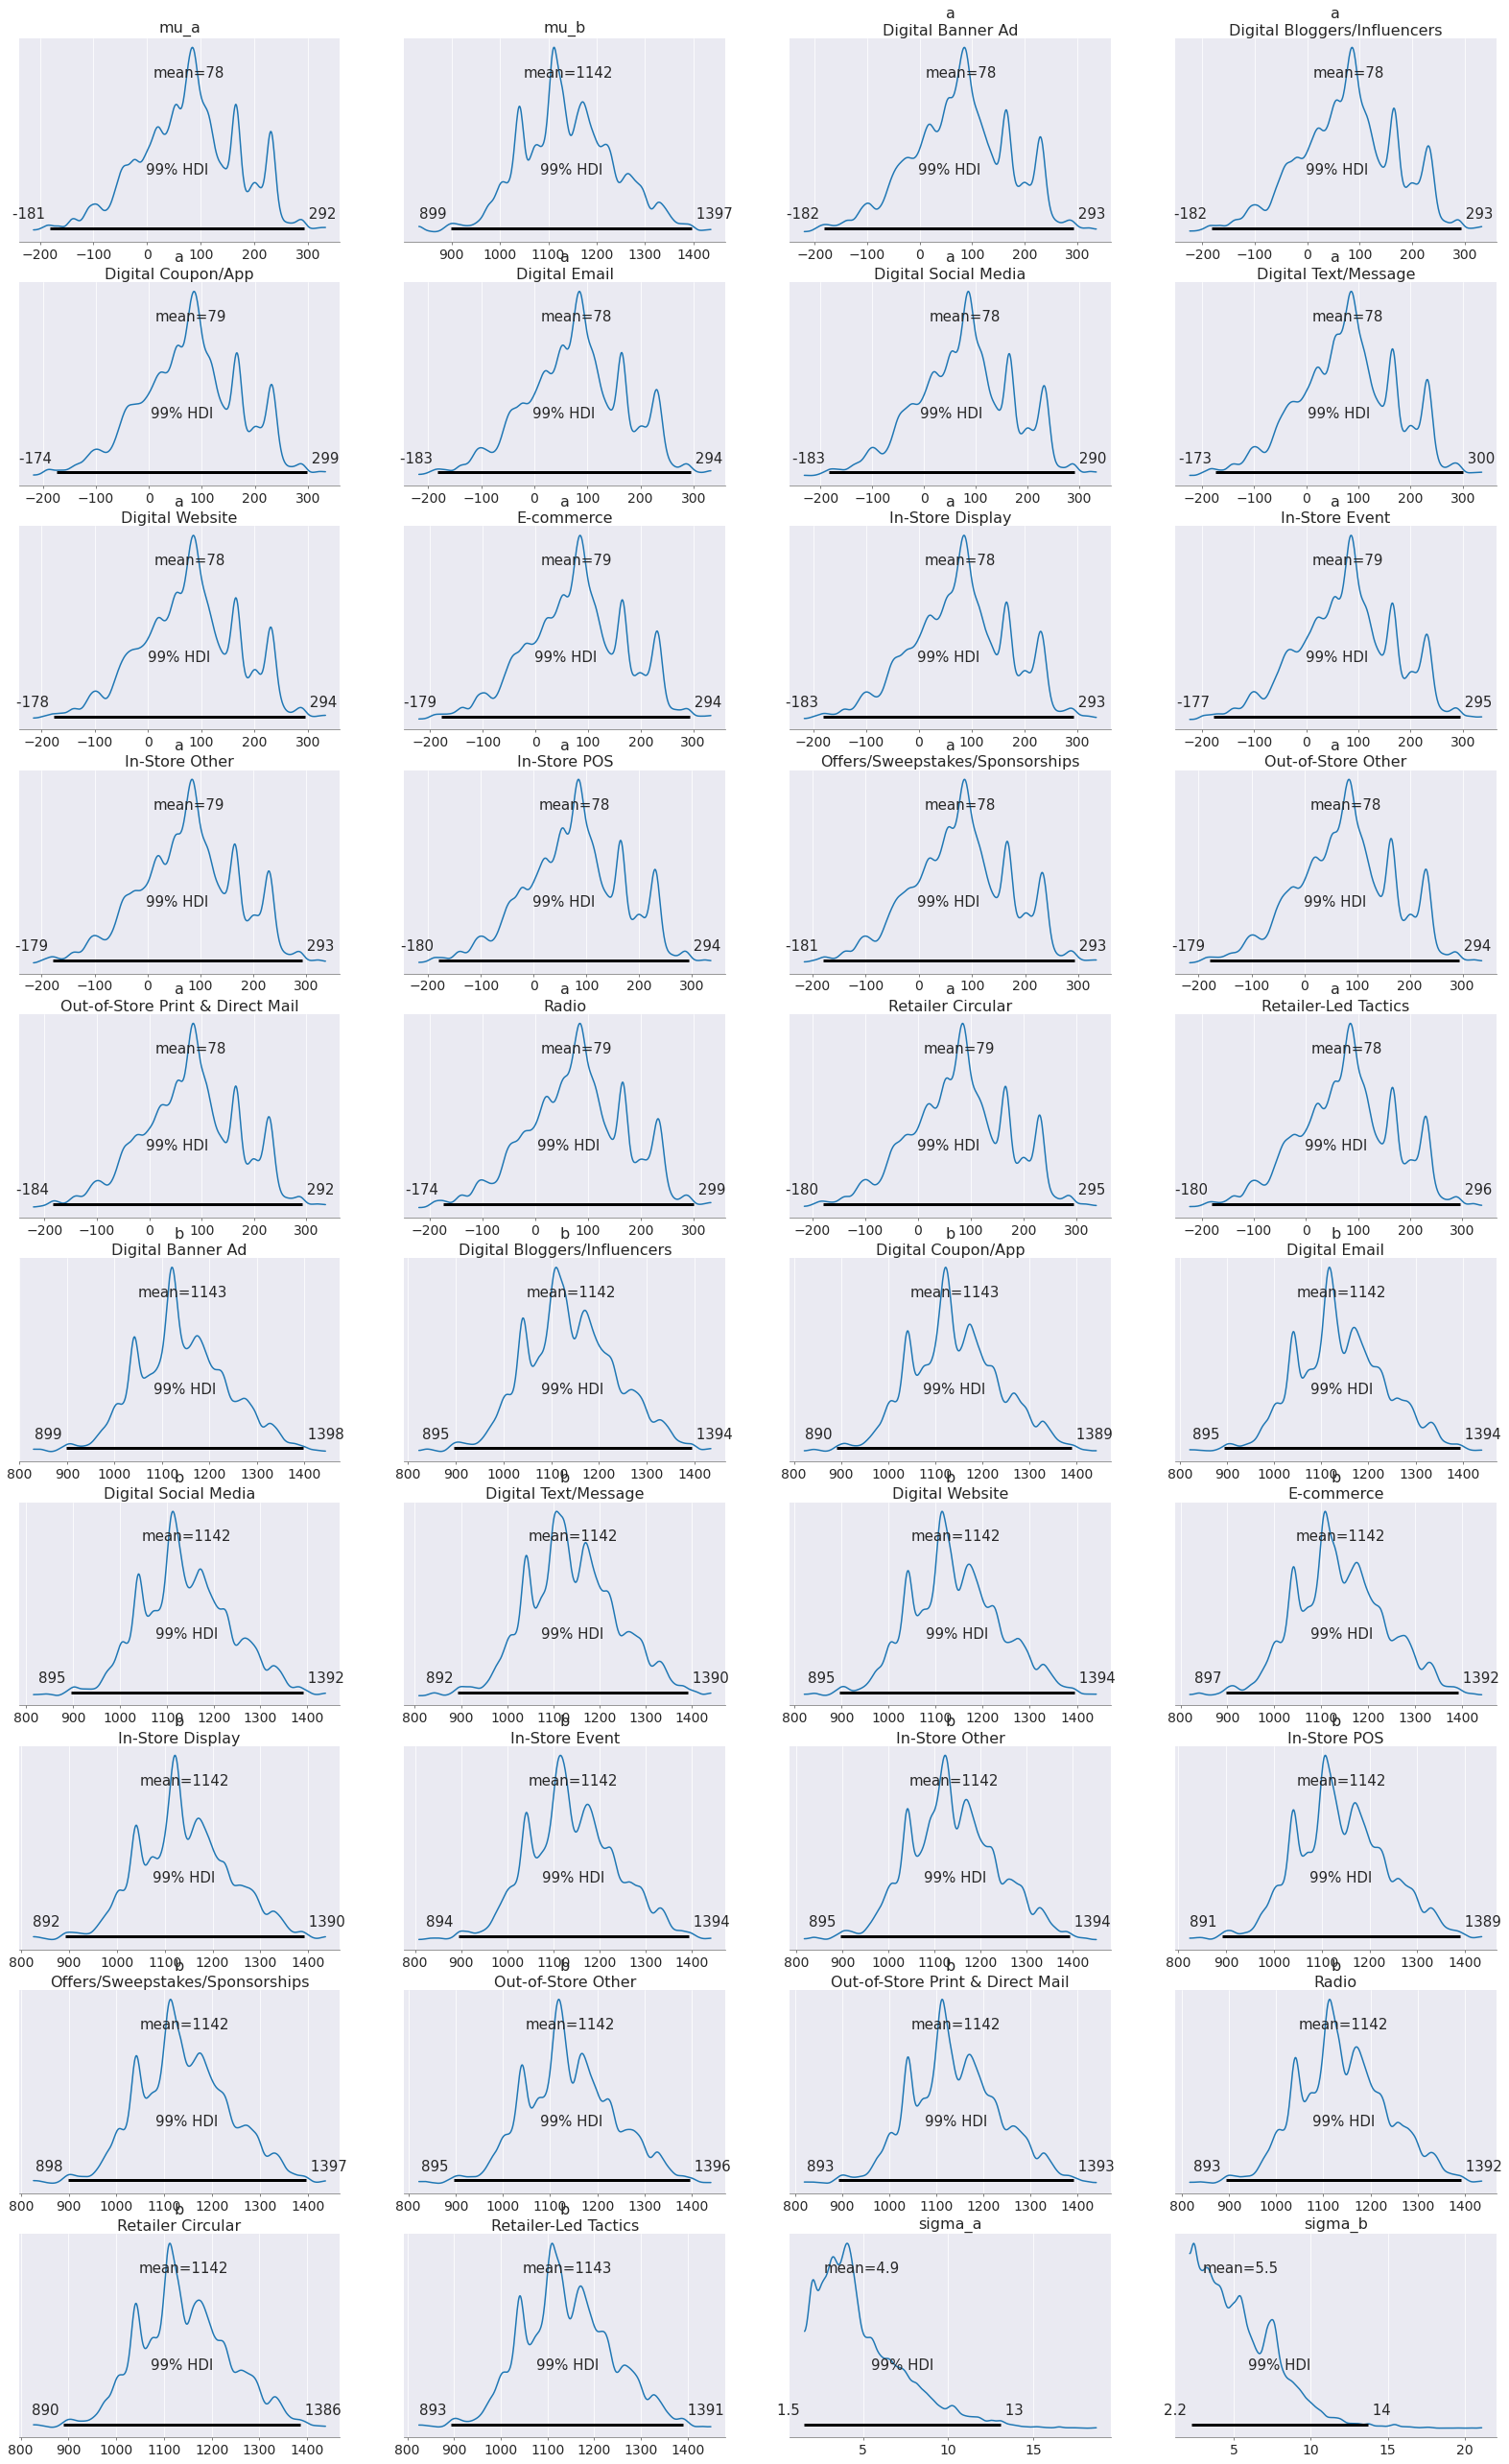

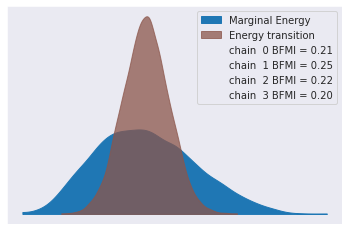

In [145]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);
# az.plot_trace(hierarchical_trace, divergences='top')
print(az.summary(hierarchical_trace))
az.mcse(hierarchical_trace)
print(az.ess(hierarchical_trace))
az.plot_posterior(hierarchical_trace, hdi_prob=0.99);
az.plot_energy(hierarchical_trace);
pm.model_to_graphviz(hierarchical_model)

In [27]:
# az.plot_kde(df_nostr['FeatwoDispACV'].values, rug=True, label='FeatwoDispACV',
#             figsize=(12, 8))
# plt.yticks([0], alpha=0);

In [28]:
# ppc = pm.sample_posterior_predictive(trace_sales, samples=20000, model=model_sales)
# _, ax = plt.subplots(figsize=(10, 5))
# ax.hist([g.mean() for g in ppc['g']], bins=19, alpha=0.5)
# ax.axvline(df_final['Total Sales'].mean())
# ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [29]:
# az.plot_ppc(bmb_fitted, figsize=(12, 12))